In [1]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

/home/ntt203/.conda/envs/raffle_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-23 11:16:45,112	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
from agox.models.descriptors.fingerprint import Fingerprint
from agox.models.descriptors import Voronoi
import numpy as np

template = Atoms("", cell=np.eye(3) * 3.567, pbc=True)
diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="C8",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=environment
)


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│     C = 8                                                                    │
│ Template formula:                                                            │
│ Full formula: C8                                                             │
│ Cell:                                                                        │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
╰──────────────────────────────────────────────────────────────────────────────╯

In [4]:
# import glob
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()
# # for each POSCAR_[0-9] in iteration*/, read in to Atoms() object and attach calculator
# poscar_files = glob.glob("iteration*/POSCAR_[0-9]")
# atoms_list = []
# for poscar_file in poscar_files:
#   atoms = read(poscar_file)
#   atoms.calc =calc
#   atoms_list.append(atoms)


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [5]:
graph_sorting = Analysis(descriptor=graph_descriptor, directories=["."], sample_size=100)

In [ ]:
structures = read("DTMP/unrlxd_structures_seed0.traj", index=":")
for structure in structures:
  structure.calc = calc

In [19]:
unique, count = graph_sorting.sort_structures(structures=structures)
print("Repeats of unique structures: ", count)

Total number of structures: 1000
Number of unique structures: 100
Repeats of unique structures:  [38, 24, 4, 5, 1, 5, 5, 1, 1, 10, 3, 7, 1, 2, 1, 1, 1, 1, 6, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 9, 1, 2, 1, 1, 1, 3, 2, 1, 1, 6, 1, 2, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


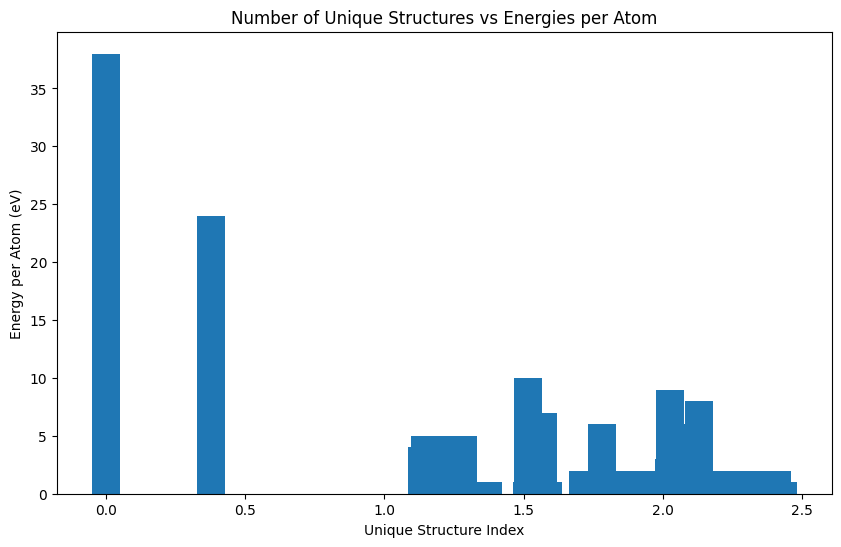

In [20]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unique]
delta_en_per_atom = energies_per_atom - np.min(energies_per_atom)

# Plot the number of unique structures vs the energies per atom
plt.figure(figsize=(10, 6))
plt.bar(delta_en_per_atom, count, width=0.1)
plt.xlabel('Unique Structure Index')
plt.ylabel('Energy per Atom (eV)')
plt.title('Number of Unique Structures vs Energies per Atom')
plt.show()

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)

In [11]:
# graph_descriptor.get_features(unique[0])
pca.fit(np.squeeze([arr for arr in descriptor.get_features(unique)]))

PCA(n_components=2)

In [12]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.57149203 0.11602846]
[24.03224322 10.82857967]


In [13]:
X_reduced = pca.fit_transform(np.squeeze([arr for arr in descriptor.get_features(unique)]))

In [14]:
plt.figure(1, figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

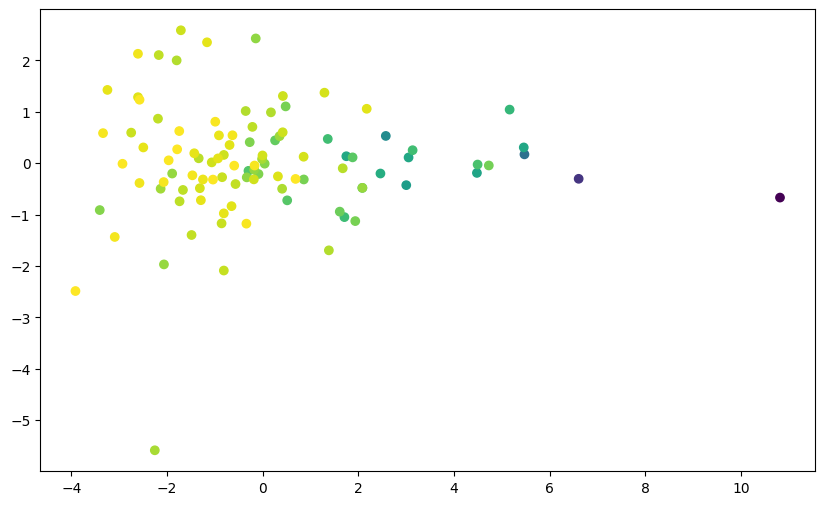

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=delta_en_per_atom, cmap="viridis")